# Redes Convolucionais - Parte 1

começando com obs:

1. aqui trato apenas do processamento da matriz de entrada, na parte 2 falarei sobre classificação e treinamento
2. as referências ao final tem muito mais detalhes do que escrevi aqui, recomendo muito

In [1]:
%pylab inline

from torch import nn                    # para a classe que contém a rede neural
from torch.nn import functional as F    #

from torch.utils.data import DataLoader #
                                        #
import torchvision                      #  para leitura do dataset
from torchvision import transforms      #

Populating the interactive namespace from numpy and matplotlib


## Funcionamento

O objetivo da coisa toda é, a partir de uma matriz de tamanho razoável, ser possível chegar a um array relativamente pequeno e que represente a matriz de entrada ao ponto de ser possível reconhecer (classificar) o conteúdo depois que a rede neural estiver treinada.

Na classe abaixo ela não está completa, falta a função forward e algumas camadas de ativação, implementei apenas o tratamento dado à matriz para entender como funciona e criei uma função que ajuda a coletar os dados para análise.

Normalmente o procedimento é:

1. filtrar
2. ativação (normalmente usando a função ReLU)
3. max pooling

Essa camada de filtragem de conteúdo da matriz gerando uma matriz menor é feita pela classe `nn.Conv2d`, na imagem abaixo há uma explicação visual disso:

![](http://adventuresinmachinelearning.com/wp-content/uploads/2017/04/Moving-filter.jpg)

_fonte da imagem: http://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/_

Sei que não ficou claro assim de cara, mas garanto que a melhor explicação que encontrei sobre isso está no 1º link das referências que usei ao final desse arquivo.

a 2ª etapa, ativada pela função `F.relu` ajuda diminuir a gradação entre os valores mais altos e mais baixos, "achatando" os valores mais baixos, na documentação do pytorch há gráficos para todas as funções de ativação: https://pytorch.org/docs/stable/nn.html#relu

a 3ª fase se resume a percorrer "quadrantes" na matriz e armazenar o valor máximo daquela região analisada, a imagem abaixo mostra isso de forma bem clara:

![](http://www.computacaointeligente.com.br/wp-content/uploads/2017/07/pooling-768x377.jpg)

_fonte da imagem: http://www.computacaointeligente.com.br/artigos/redes-neurais-convolutivas-cnn/_

obs.: não coloquei um valor para o parâmetro _stride_, que por padrão no pytorch equivale a 1, ele indica quantas posições o quadrante anda para o lado e para baixo, e o kernel_size indica o tamanho do quadrante, assim também acaba influencia no tamanho da matriz ao final.

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 1, kernel_size=5) # se a entrada for uma matriz rgb, deixar o canal de enrtada com valor "3"
        self.conv2 = nn.Conv2d(1, 1, kernel_size=5)
        
        self.mp = nn.MaxPool2d(kernel_size=2)

    def view_phases(self, x):
        cv1 = self.conv1(x)
        rl1 = F.relu(cv1)
        mp1 = self.mp(rl1)
        
        cv2 = self.conv2(mp1)
        rl2 = F.relu(cv2)
        mp2 = self.mp(rl2)
        
        return {
            "conv1" : cv1,
            "relu1" : rl1,
            "maxpool1" : mp1,
            "conv2" : cv2,
            "rwlu2" : rl2,
            "maxpool2": mp2
        }


^ Notas sobre o que há acima ^

> breve esclarecimento sobre `nn.Conv2d`: `nn.Conv2d(in_channels, out_channels, kernel_size)` ~> são esses os atributos obrigatórios

habitalmente em `nn.Conv2d`, e falo isso com base em absolutamente todos os códigos que vi, no canal de saída, há um valor maior que o da entrada, mas isso prejudica a visualização quando se busca mostrar as coisas de forma mais didática, por isso optei por deixar o mesmo tamanho, embora haja diferenças em relação à matriz de entrada.

---

## Processamento:

inicialmente lendo a base de dados

In [3]:
convnet = ConvNet()

In [4]:
trans = transforms.Compose([transforms.ToTensor()])

data_path = "images_art/images/mnist/"
data = torchvision.datasets.MNIST(data_path, transform=trans) # download=True)

batch_size = 30
test = DataLoader(dataset=data, batch_size=batch_size, shuffle=True)

In [5]:
frag = iter(test).next() # um fragmento do dataset

Essa variável '`frag`' é uma lista composta de 2 elementos: as matrizes corrspondentes às imagens e os valores correspondentes, neste caso o valor dos números manuscritos.

Em `In [4]` transformamos o conteúdo do dataset em tensor do pytorch, para que possamos visualizar no matplotlib, precisaremos que uma matriz de dimensões adequadas seja passado para o a função matshow (ou imshow, que também funciona nesse caso). Para isso fazemos:

1. tensor.view() # similar ao array.reshape() do numpy
2. .detach()     # que destaca o conteúdo do resto do tensor
3. .numpy()      # converte para array do numpy

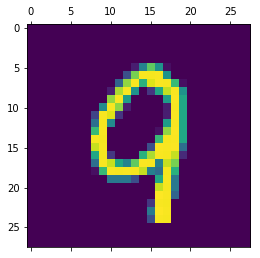

In [6]:
index = 3

matshow(frag[0][index].view(28, 28).detach().numpy()) # dando uma olhada na entrada

In [7]:
out = convnet.view_phases(frag[0])

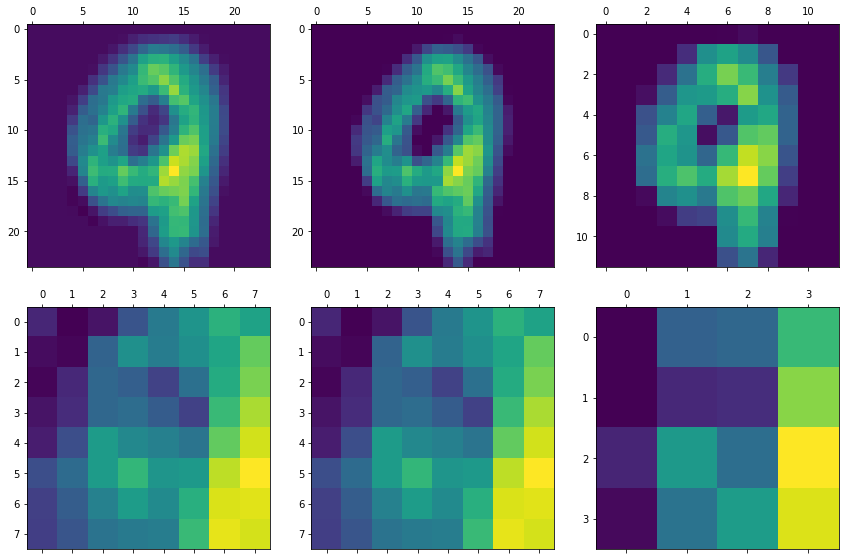

In [8]:
fig, axs = subplots(nrows=2, ncols=3, figsize=(12, 8))
fig.tight_layout()

axs[0, 0].matshow(out['conv1'][index].view(24, 24).detach().numpy())
axs[0, 1].matshow(out['relu1'][index].view(24, 24).detach().numpy())
axs[0, 2].matshow(out['maxpool1'][index].view(12, 12).detach().numpy())

axs[1, 0].matshow(out['conv2'][index].view(8, 8).detach().numpy())
axs[1, 1].matshow(out['conv2'][index].view(8, 8).detach().numpy())
axs[1, 2].matshow(out['maxpool2'][index].view(4, 4).detach().numpy());

Acima vemos em cada linha, a ação de uma camada convolucional, seguindo a ordem das colunas:

1. coluna: `nn.Conv2d`
2. coluna: `F.relu`
3. coluna: `nn.MaxPool2d`

É bem notável a redução do tamanho da matriz, que numa situação mais próxima de utilização real, seria redimensionada para um vetor a fim de ser processada por mais camadas de ativação (e em todos os tutoriais que vi eram uma função linear e acho que só 1 usava mais uma vez o ReLU).

Obs.: o esquema de cores não leva em consideração os mesmos valores de todos os heatmap, então evidenciam mais onde há valores mais altos e mais baixos do que os valores em seu sentido absoluto.

# minhas referências*:

O vídeos mais claro e esclarecedor que me ajudou em tudo: https://www.youtube.com/watch?v=FmpDIaiMIeA

também recomendo muito: http://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

em português e muito bem escrito: http://www.computacaointeligente.com.br/artigos/redes-neurais-convolutivas-cnn/

* *ao menos as que consegui lembrar*